In [1]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))

from gan.gan_model import cont_style_munit_enc
from models.munit.enc_dec import MunitEncoder
from parameters.dataset import DatasetParameters
from parameters.deformation import DeformationParameters
from parameters.gan import GanParameters, MunitParameters
import albumentations
from albumentations.pytorch.transforms import ToTensor as AlbToTensor
from dataset.cardio_dataset import ImageMeasureDataset
from torch.utils import data
from transforms_utils.transforms import MaskToMeasure
import numpy as np
from transforms_utils.transforms import MeasureToMask, ToNumpy, NumpyBatch, ToTensor, MaskToMeasure, ResizeMask
from dataset.lazy_loader import LazyLoader, W300DatasetLoader, CelebaWithKeyPoints, Celeba
from dataset.toheatmap import ToHeatMap, heatmap_to_measure
from modules.hg import hg2, final_preds_untransformed, hg8, hg4, HG_softmax2020
from gan.gan_model import CondStyleGanModel, CondGen3, CondDisc3, \
    CondGenDecode
from stylegan2.model import Generator
from models.munit.enc_dec import MunitEncoder, StyleEncoder

In [2]:
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure, UniformMeasure2DFactory, \
UniformMeasure2D01
import torch
from torch import nn
import random
from modules.linear_ot import SOT, PairwiseDistance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

def content_to_measure(content):
    batch_size = content.shape[0]
    pred_measures: ProbabilityMeasure = ProbabilityMeasure(
            torch.ones(batch_size, 70, device=device) / 70,
            content.reshape(batch_size, 70, 2)
        )
    return pred_measures

def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)

    return res

def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises

def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]



In [5]:

def verka(encoder: nn.Module):
    res = []
    for i, (image, lm) in enumerate(LazyLoader.celeba_test(64)):
        content = encoder(image.cuda())
        mes = UniformMeasure2D01(lm.cuda())
        pred_measures: UniformMeasure2D01 = UniformMeasure2DFactory.from_heatmap(content)
        res.append(Samples_Loss(p=1)(mes, pred_measures).item() * image.shape[0])
    return np.mean(res)/len(LazyLoader.celeba_test(1).dataset)


def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]


def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)
    return res

In [56]:
device = "cuda:3"
torch.cuda.set_device(device)
encoder_HG = HG_softmax2020(num_classes=68, heatmap_size=64)

print("HG")

latent = 512
n_mlp = 5
size = 256

generator = CondGen3(Generator(
    size, latent, n_mlp, channel_multiplier=1
))

discriminator = CondDisc3(
    size, channel_multiplier=1
)
style_encoder = StyleEncoder(style_dim=latent)

# generator = nn.DataParallel(generator, [3])
# discriminator = nn.DataParallel(discriminator, [3])

HG


In [76]:
weights = torch.load(f"/raid/data/saved_models/stylegan2_new_160000.pt", map_location="cpu")
print(weights.keys())
style_encoder.load_state_dict(weights['s'])
style_encoder = style_encoder.to(device)
generator.load_state_dict(weights['g'])
generator = generator.to(device)
# weights = torch.load(f"/raid/data/saved_models/hg2_e29.pt", map_location="cpu")
encoder_HG.load_state_dict(weights['c'])
encoder_HG = encoder_HG.to(device)


dict_keys(['g', 'd', 'c', 's'])


In [77]:
class Args:
    iter = 800000
    batch = 8
    n_sample = 64
    size = 256
    r1 = 10
    path_regularize = 2
    path_batch_shrink = 2
    d_reg_every = 16
    g_reg_every = 4
    mixing = 0.9
    ckpt = None
    lr = 0.002
    channel_multiplier = 1
    wandb = 'store_true'
    local_rank = 0
    image_size = 256
    batch_size = 1
    measure_size = 70 
    ct = 0.0001
    ca = 0.0002
    cw = 0.002
    ngf = 64
    ndf = 64 
    L1 = 2
    noise_size = 256.0
    input_dim = 3 
    dim = 16
    style_dim = 512 
    n_downsample = 2
    n_res = 4 
    activ = 'lrelu'
    pad_type = 'replicate'
    norm = 'none'
    mlp_dim = 256
    n_layer = 8
    num_scales = 1
    

munit_args=Args()
args = Args()
transform = albumentations.Compose(
        [
            albumentations.Resize(munit_args.size, munit_args.size),
            albumentations.ShiftScaleRotate(p=1, rotate_limit=10),
            albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            AlbToTensor()
        ]
    )

    # dataset = ImageFolder("/raid/data/celeba", transform=transform)

dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=1,
    sampler=data_sampler(dataset, shuffle=False, distributed=False),
    drop_last=True,
)

In [85]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()

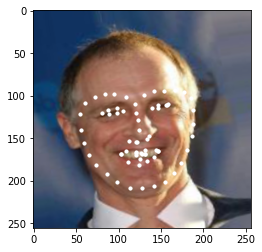

In [171]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
with torch.no_grad():
    landmarks = encoder_HG(test_img)
pred_measures = UniformMeasure2DFactory.from_heatmap(landmarks)
test_img = (test_img + 1) / 2
x = np.around((pred_measures.coord[0,:,0] * 256).detach().cpu().numpy())
y = np.around((pred_measures.coord[0,:,1] * 256).detach().cpu().numpy())
plt.imshow(test_img.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(x, y, s=10, marker='o', c='w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


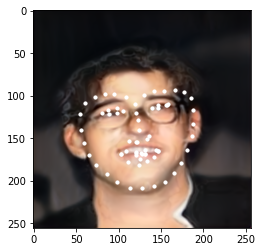

In [178]:
noise1 = mixing_noise(1, latent, 0.9, device)
with torch.no_grad():
    fake1, _ = generator(landmarks, noise1)
fake1 = (fake1 + 1) / 2
plt.imshow(fake1.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(x, y, s=10, marker='o', c='w')